 # KV Caching in Language Models: A Visual Demonstration

 This notebook provides a stupidly simple demonstration of KV (Key-Value) caching in transformer language models, using the TinyLlama model as an example. We'll explore:

 1. How attention mechanisms work in transformer models
 2. What Q, K, V projections are and how they're computed
 3. How KV caching optimizes inference
 4. The impact of KV caching on attention patterns and computation efficiency

 ## What is KV Caching?

 KV caching is an optimization technique used during autoregressive text generation to avoid redundant computations. In a typical transformer model:

 - For each token, we compute Query (Q), Key (K), and Value (V) matrices
 - During generation, we only add one new token at a time
 - Previous tokens' K and V values don't change when generating new tokens
 - KV caching stores these K and V values to avoid recomputing them

 ## 1. Setup and Model Initialization

 First, let's import the necessary libraries and load the TinyLlama model.

In [ ]:
import torch
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys

sys.path.append("../src")
# Import custom utilities
from attention_helpers.qkvo_hooks import capture_model_attention_internals
from attention_helpers.gqa import reshape_llama_attention, compute_multihead_attention
from plot_helpers.plotter import (
    plot_single_matrix,
    visualize_gqa_attention,
    plot_attention_matrices,
    get_axis_limits,
    plot_kv_cache_verification,
    plot_hybrid_verification,
)

# Create data directory if it doesn't exist
Path("../data").mkdir(exist_ok=True)

 ## 2. Load the TinyLlama Model

 We'll use the TinyLlama-1.1B-Chat model for our experiments. This is a smaller model that demonstrates the same principles as larger LLMs.

In [ ]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0", padding=False
)
model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    device_map="cpu",
    torch_dtype=torch.float16,
)

# Display model information
print(f"Model Parameters: {model.num_parameters():,}")
print(f"Model Architecture: {model.config.architectures[0]}")
print(f"Model Context Length: {model.config.max_position_embeddings}")

Model Parameters: 1,100,048,384
Model Architecture: LlamaForCausalLM
Model Context Length: 2048


 ## 3. Define Helper Functions for Text Generation

 Let's define a function to generate text using the TinyLlama model with a chat template.

In [ ]:
def generate_text(
    messages,
    model,
    tokenizer,
    max_tokens=100,
    temperature=0,
    verbose=True,
    padding=True,
    truncation=True,
):
    """
    Generate text using TinyLlama model with chat template

    Args:
        messages (list): List of message dictionaries with 'role' and 'content'
        model: The language model to use
        tokenizer: The tokenizer to use
        max_tokens (int): Maximum number of tokens to generate
        temperature (float): Sampling temperature (0.0 = deterministic)

    Returns:
        str: Generated text
    """
    # Apply chat template to format messages
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        padding=padding,
        truncation=truncation,
    )

    # Encode the prompt with attention mask
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=padding,
        truncation=truncation,
        return_attention_mask=True,
    )

    if verbose:
        # Print tokenization information
        print("\n\nTokenization Information:")
        text = tokenizer.apply_chat_template(messages, tokenize=False, padding=False)
        tokens = tokenizer.encode(
            text, padding=False, truncation=True, return_tensors="pt"
        )
        print(f"Input sequence length: {tokens.shape[1]} tokens")

        # Create DataFrame for token visualization
        token_data = {
            "token_index": range(len(tokens[0])),
            "token": tokens[0].tolist(),
            "decoded_token": [tokenizer.decode([t]) for t in tokens[0]],
        }
        df = pd.DataFrame(token_data)
        print("\nToken Details:")
        print(df.to_string(index=False))

    # Generate with attention mask
    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_tokens,
        do_sample=(temperature > 0),
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode and return the generated text, keeping special tokens
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
    if verbose:
        print(
            f"\nGenerated tokens: {len(outputs[0]) - len(inputs.input_ids[0])} tokens"
        )
        print(f"Total tokens in final sequence: {len(outputs[0])}")
        print(f"\nGenerated Text:\n{decoded_output}")
        print("--------------------------------")
    return decoded_output

 ## 4. Define Example Prompts

 Let's create two different prompts that we'll use to demonstrate KV caching.
 Note that the prompts have some common prefix, which will be important for our caching demonstration.

In [ ]:
SYSTEM_PROMPT = "You are a helpful assistant."

# First prompt: About the capital of India
msg1 = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {
        "role": "user",
        "content": "What is the capital of India?",
    },
]

# Second prompt: About the capital of France
msg2 = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {
        "role": "user",
        "content": "What is the capital of France? Answer the question in just one word not more than that.",
    },
]

 ## 5. Run Example Generation

 Let's generate a response for the first prompt to see how the model works.

In [ ]:
# Run example text generation
generated_text = generate_text(msg1, model, tokenizer, verbose=True)



Tokenization Information:
Input sequence length: 32 tokens

Token Details:
 token_index  token decoded_token
           0      1           <s>
           1    529             <
           2  29989             |
           3   5205        system
           4  29989             |
           5  29958             >
           6     13            \n
           7   3492           You
           8    526           are
           9    263             a
          10   8444       helpful
          11  20255     assistant
          12  29889             .
          13      2          </s>
          14  29871              
          15     13            \n
          16  29966             <
          17  29989             |
          18   1792          user
          19  29989             |
          20  29958             >
          21     13            \n
          22   5618          What
          23    338            is
          24    278           the
          25   7483       capital
     

 ## 6. Capture Attention Internals (Q, K, V Projections)

 Now let's capture the Query, Key, and Value projections for both of our prompts.
 These are the internal matrices used by the attention mechanism in transformers.

In [ ]:
# Capture attention internals for both inputs
data_obj1 = capture_model_attention_internals(
    messages=msg1,
    model=model,
    tokenizer=tokenizer,
    padding=True,
    truncation=True,
    return_attention_mask=True,
    verbose=True,
)
data_obj2 = capture_model_attention_internals(
    messages=msg2,
    model=model,
    tokenizer=tokenizer,
    padding=True,
    truncation=True,
    return_attention_mask=True,
    verbose=True,
)

# Save the data for later use or analysis
with open("../data/msg1-qkvo.pkl", "wb") as f:
    pickle.dump(data_obj1, f)

with open("../data/msg2-qkvo.pkl", "wb") as f:
    pickle.dump(data_obj2, f)

Attention layer shapes:
Q projection: torch.Size([1, 32, 2048])
K projection: torch.Size([1, 32, 256])
V projection: torch.Size([1, 32, 256])
O projection: torch.Size([1, 32, 2048])
Attention layer shapes:
Q projection: torch.Size([1, 44, 2048])
K projection: torch.Size([1, 44, 256])
V projection: torch.Size([1, 44, 256])
O projection: torch.Size([1, 44, 2048])


 ## 7. Visualize Raw Projections (KV Cache Components)

 Let's visualize what's actually stored in the KV cache. These are the raw K and V matrices
 for a specific layer. This is what would be stored in the KV cache during generation.

Q1 shape after squeeze: torch.Size([32, 2048])
K1 shape after squeeze: torch.Size([32, 256])
V1 shape after squeeze: torch.Size([32, 256])


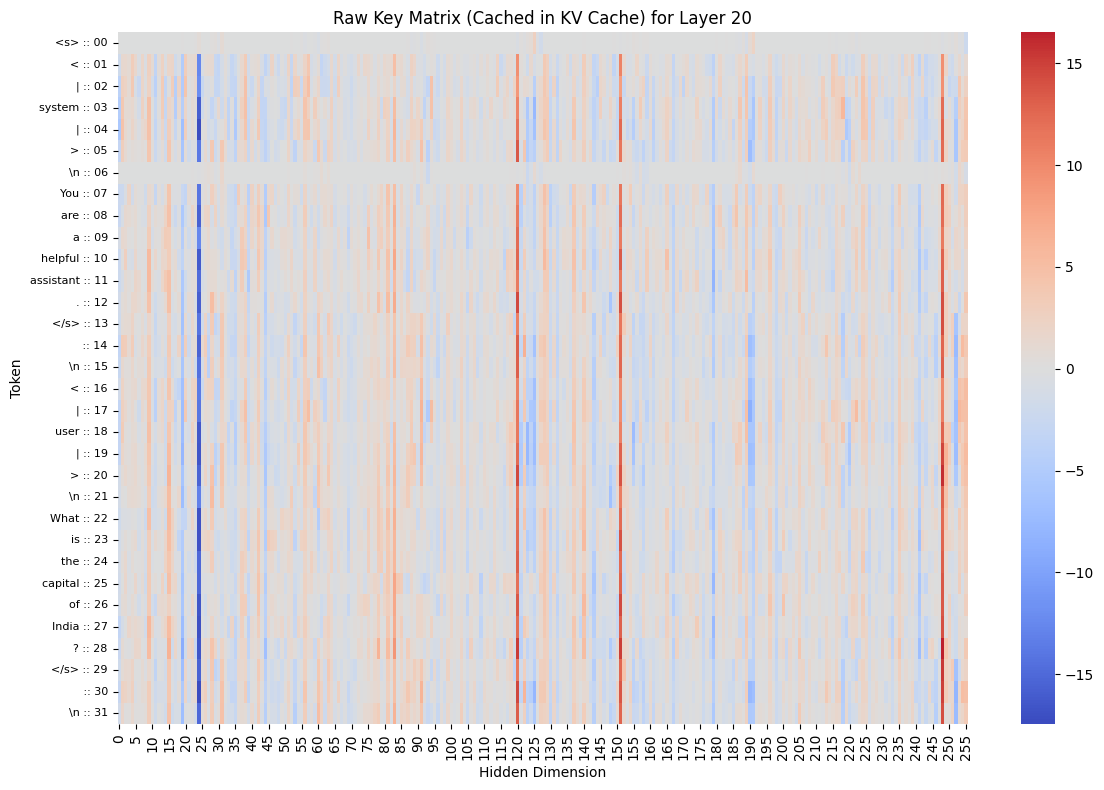

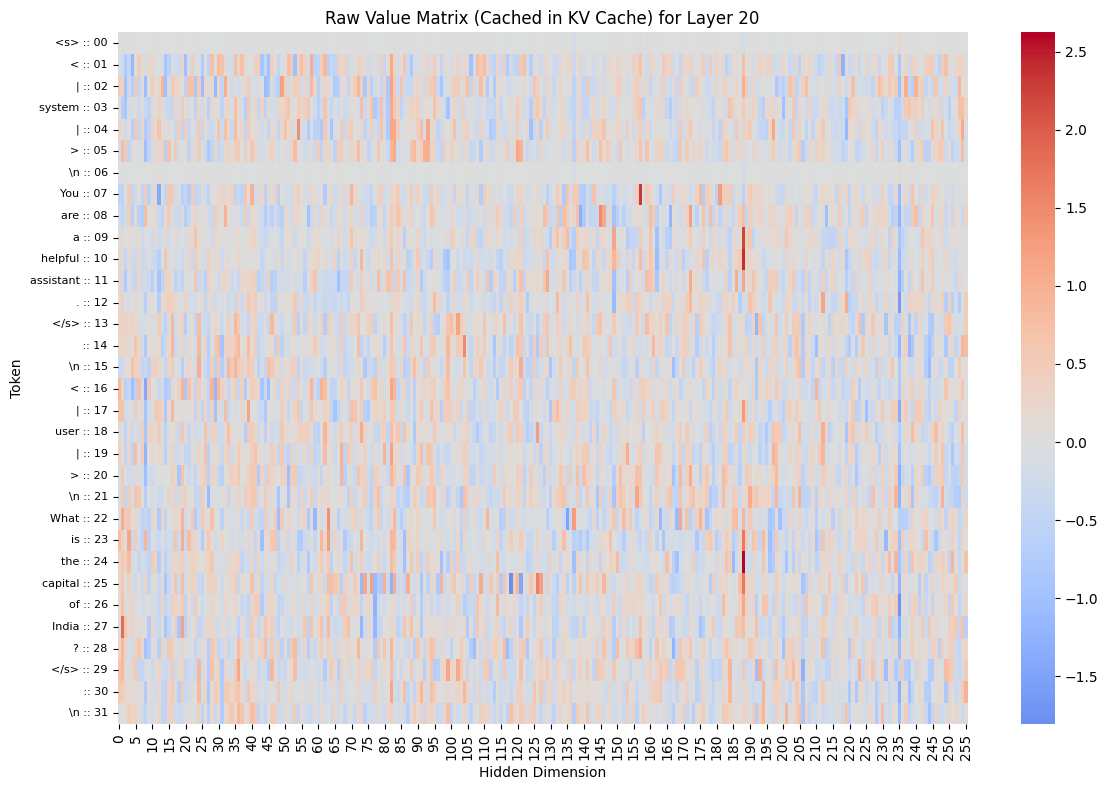

In [ ]:
# Select a layer for visualization
layer_to_visualize = 20

# Extract raw Q, K, V matrices for the selected layer
q1 = data_obj1["attention_matrices"]["q"][layer_to_visualize]
k1 = data_obj1["attention_matrices"]["k"][layer_to_visualize]
v1 = data_obj1["attention_matrices"]["v"][layer_to_visualize]

# Convert to 2D format for visualization
q1_2d = torch.squeeze(q1)  # [seq_len, q_dim]
k1_2d = torch.squeeze(k1)  # [seq_len, k_dim]
v1_2d = torch.squeeze(v1)  # [seq_len, v_dim]

print(f"Q1 shape after squeeze: {q1_2d.shape}")
print(f"K1 shape after squeeze: {k1_2d.shape}")
print(f"V1 shape after squeeze: {v1_2d.shape}")

# Visualize raw K matrix (what would be cached)
plot_single_matrix(
    k1_2d,
    matrix_type="K",
    plot_title=f"Raw Key Matrix (Cached in KV Cache) for Layer {layer_to_visualize}",
    cmap="coolwarm",
    tokens=data_obj1["decoded_input_tokens"],
)

# Visualize raw V matrix (what would be cached)
plot_single_matrix(
    v1_2d,
    matrix_type="V",
    plot_title=f"Raw Value Matrix (Cached in KV Cache) for Layer {layer_to_visualize}",
    cmap="coolwarm",
    tokens=data_obj1["decoded_input_tokens"],
)

 ## 8. Computing Attention Patterns

 Now let's compute the attention patterns for both prompts.
 First, we reshape the Q, K, V matrices to the multi-head format,
 then compute the attention scores, probabilities, and outputs.
 `[batch_size, seq_len, hidden_dim]` -> `[batch_size, num_heads, seq_len, head_dim]`

In [ ]:
# Extract Q, K, V matrices for a specific layer
layer_to_analyze = 20
q1, k1, v1 = [
    data_obj1["attention_matrices"][key][layer_to_analyze] for key in ["q", "k", "v"]
]
q2, k2, v2 = [
    data_obj2["attention_matrices"][key][layer_to_analyze] for key in ["q", "k", "v"]
]

# Reshape into multi-head format
q1_mh, k1_mh, v1_mh = reshape_llama_attention(q1, k1, v1, verbose=True)
q2_mh, k2_mh, v2_mh = reshape_llama_attention(q2, k2, v2, verbose=False)

# Compute attention separately for each message
attention_msg1 = compute_multihead_attention(q1_mh, k1_mh, v1_mh)
attention_msg2 = compute_multihead_attention(q2_mh, k2_mh, v2_mh)

# Print information about the attention heads
print(f"Grouping of queries:")
for i in list(attention_msg1["heads"].keys())[:5]:  # Just show the first 5
    print(i)
print("... (more heads)")


After squeeze:
Q shape: torch.Size([32, 2048])
K shape: torch.Size([32, 256])
V shape: torch.Size([32, 256])

Head dimensions:
Q head dim: 64
KV head dim: 32
Num Q heads: 32
Num KV heads: 8

After reshape:
Q shape: torch.Size([32, 32, 64])
K shape: torch.Size([8, 32, 32])
V shape: torch.Size([8, 32, 32])
Grouping of queries:
q_head_0_kv_head_0
q_head_1_kv_head_0
q_head_2_kv_head_0
q_head_3_kv_head_0
q_head_4_kv_head_1
... (more heads)


 ## 9. Visualizing Attention Patterns

 Let's visualize the attention patterns for each prompt.
 This shows which tokens are attending to which other tokens.

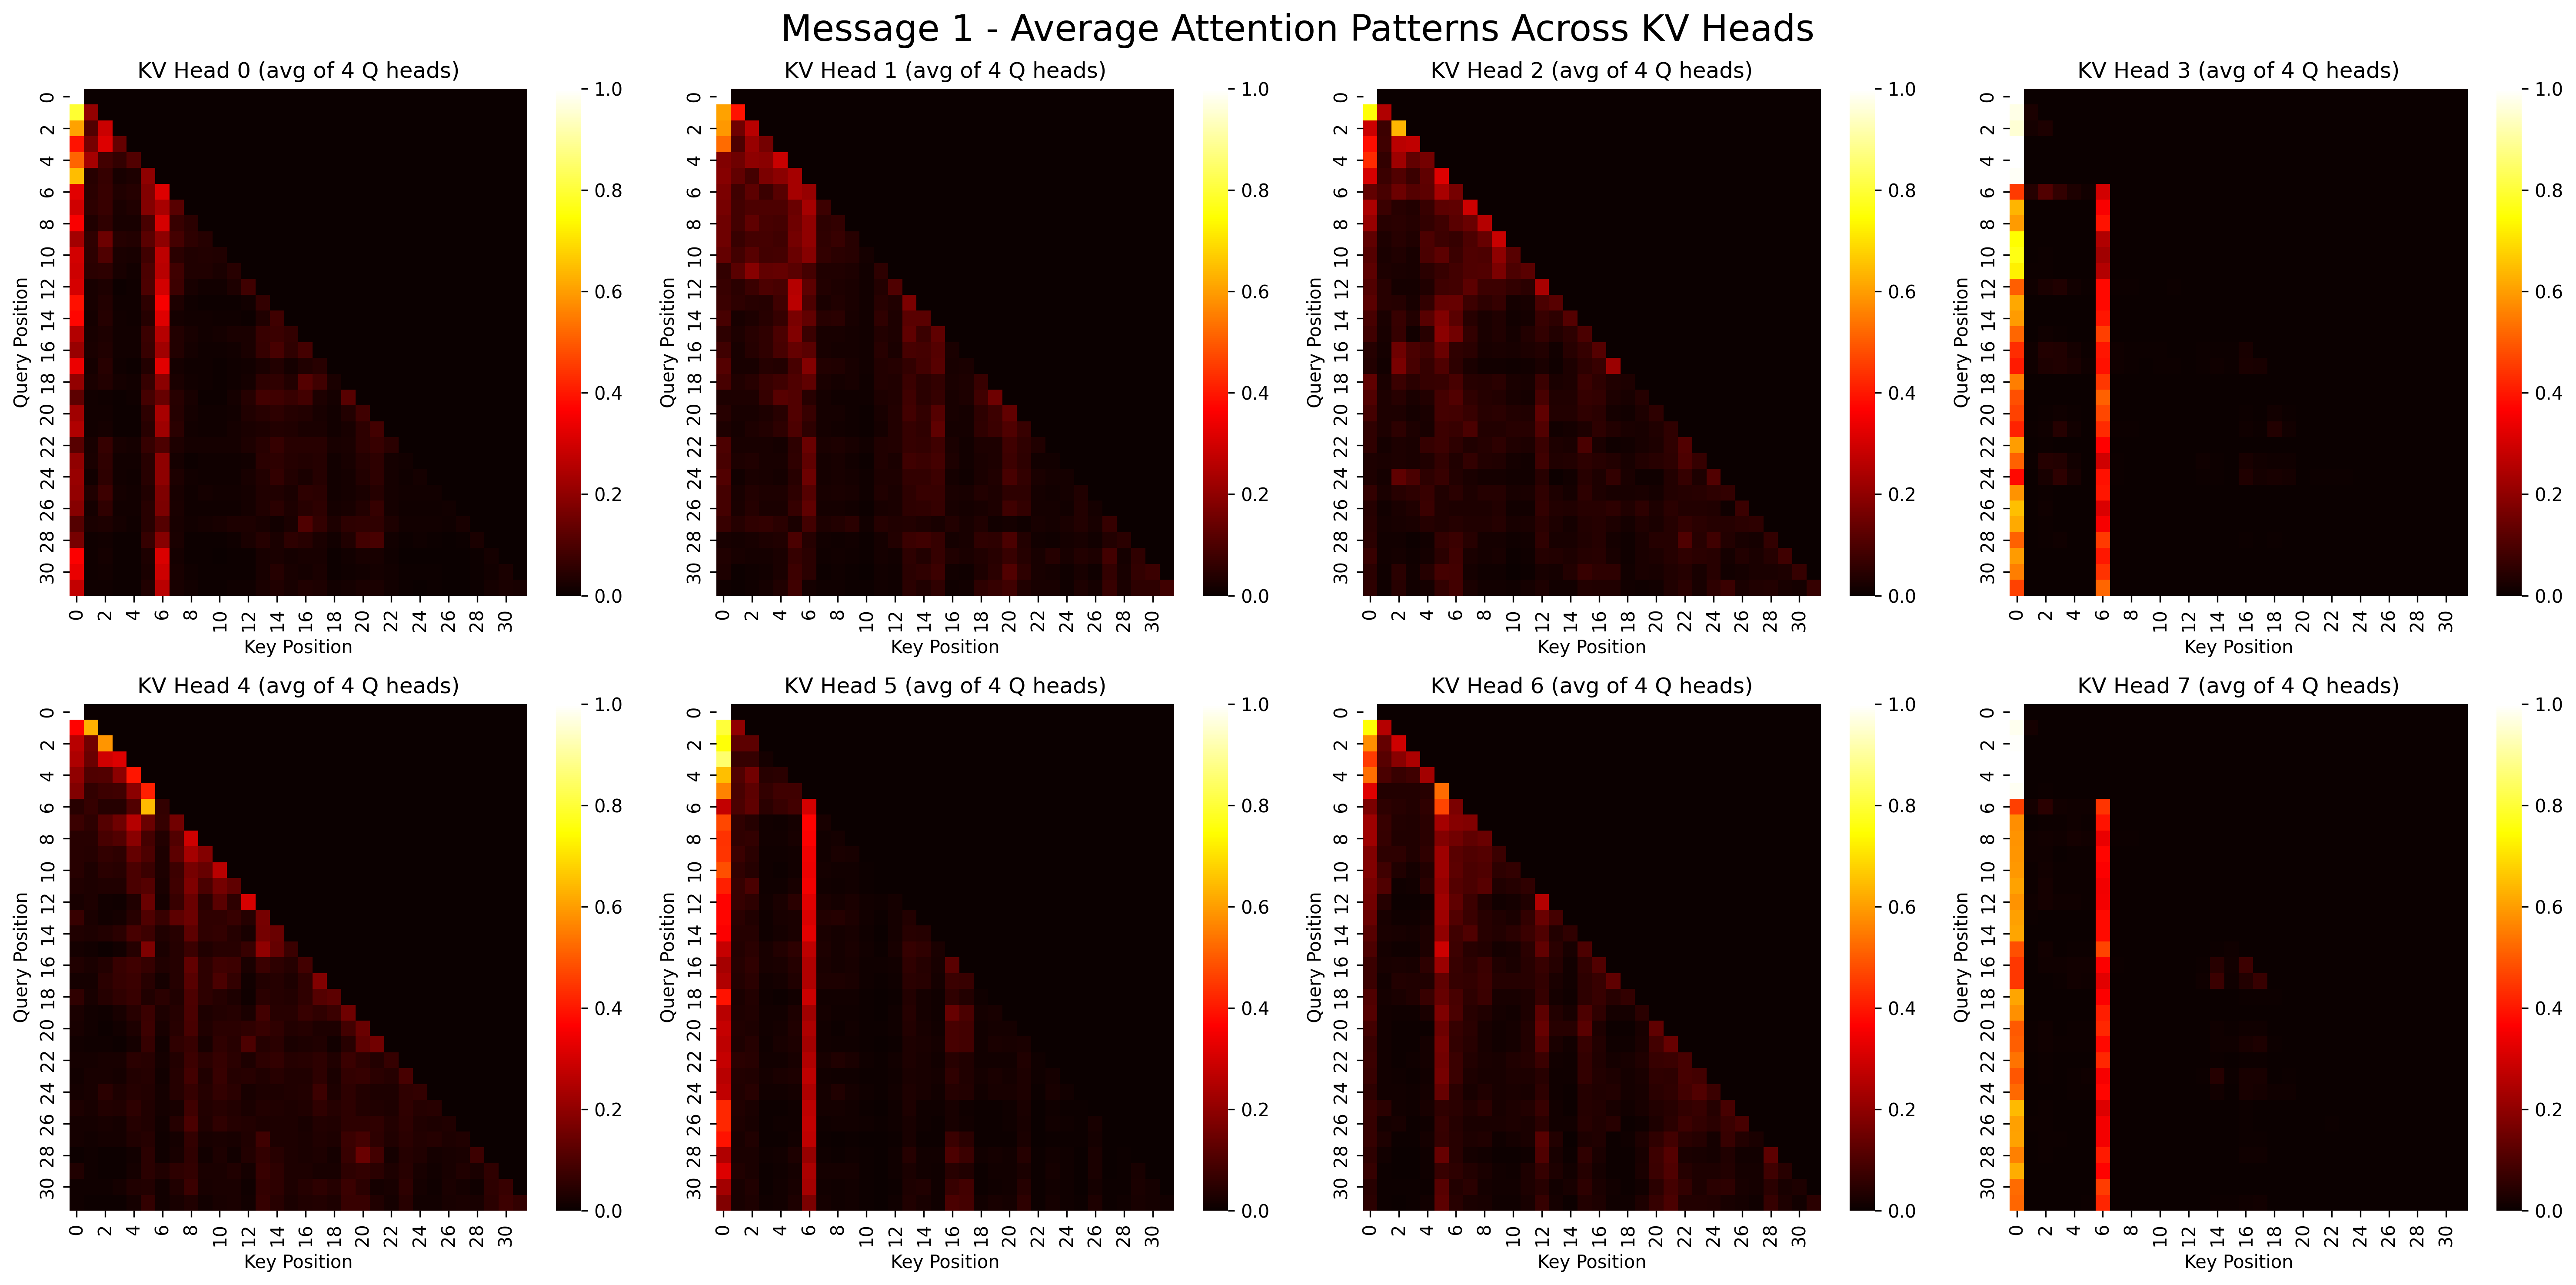

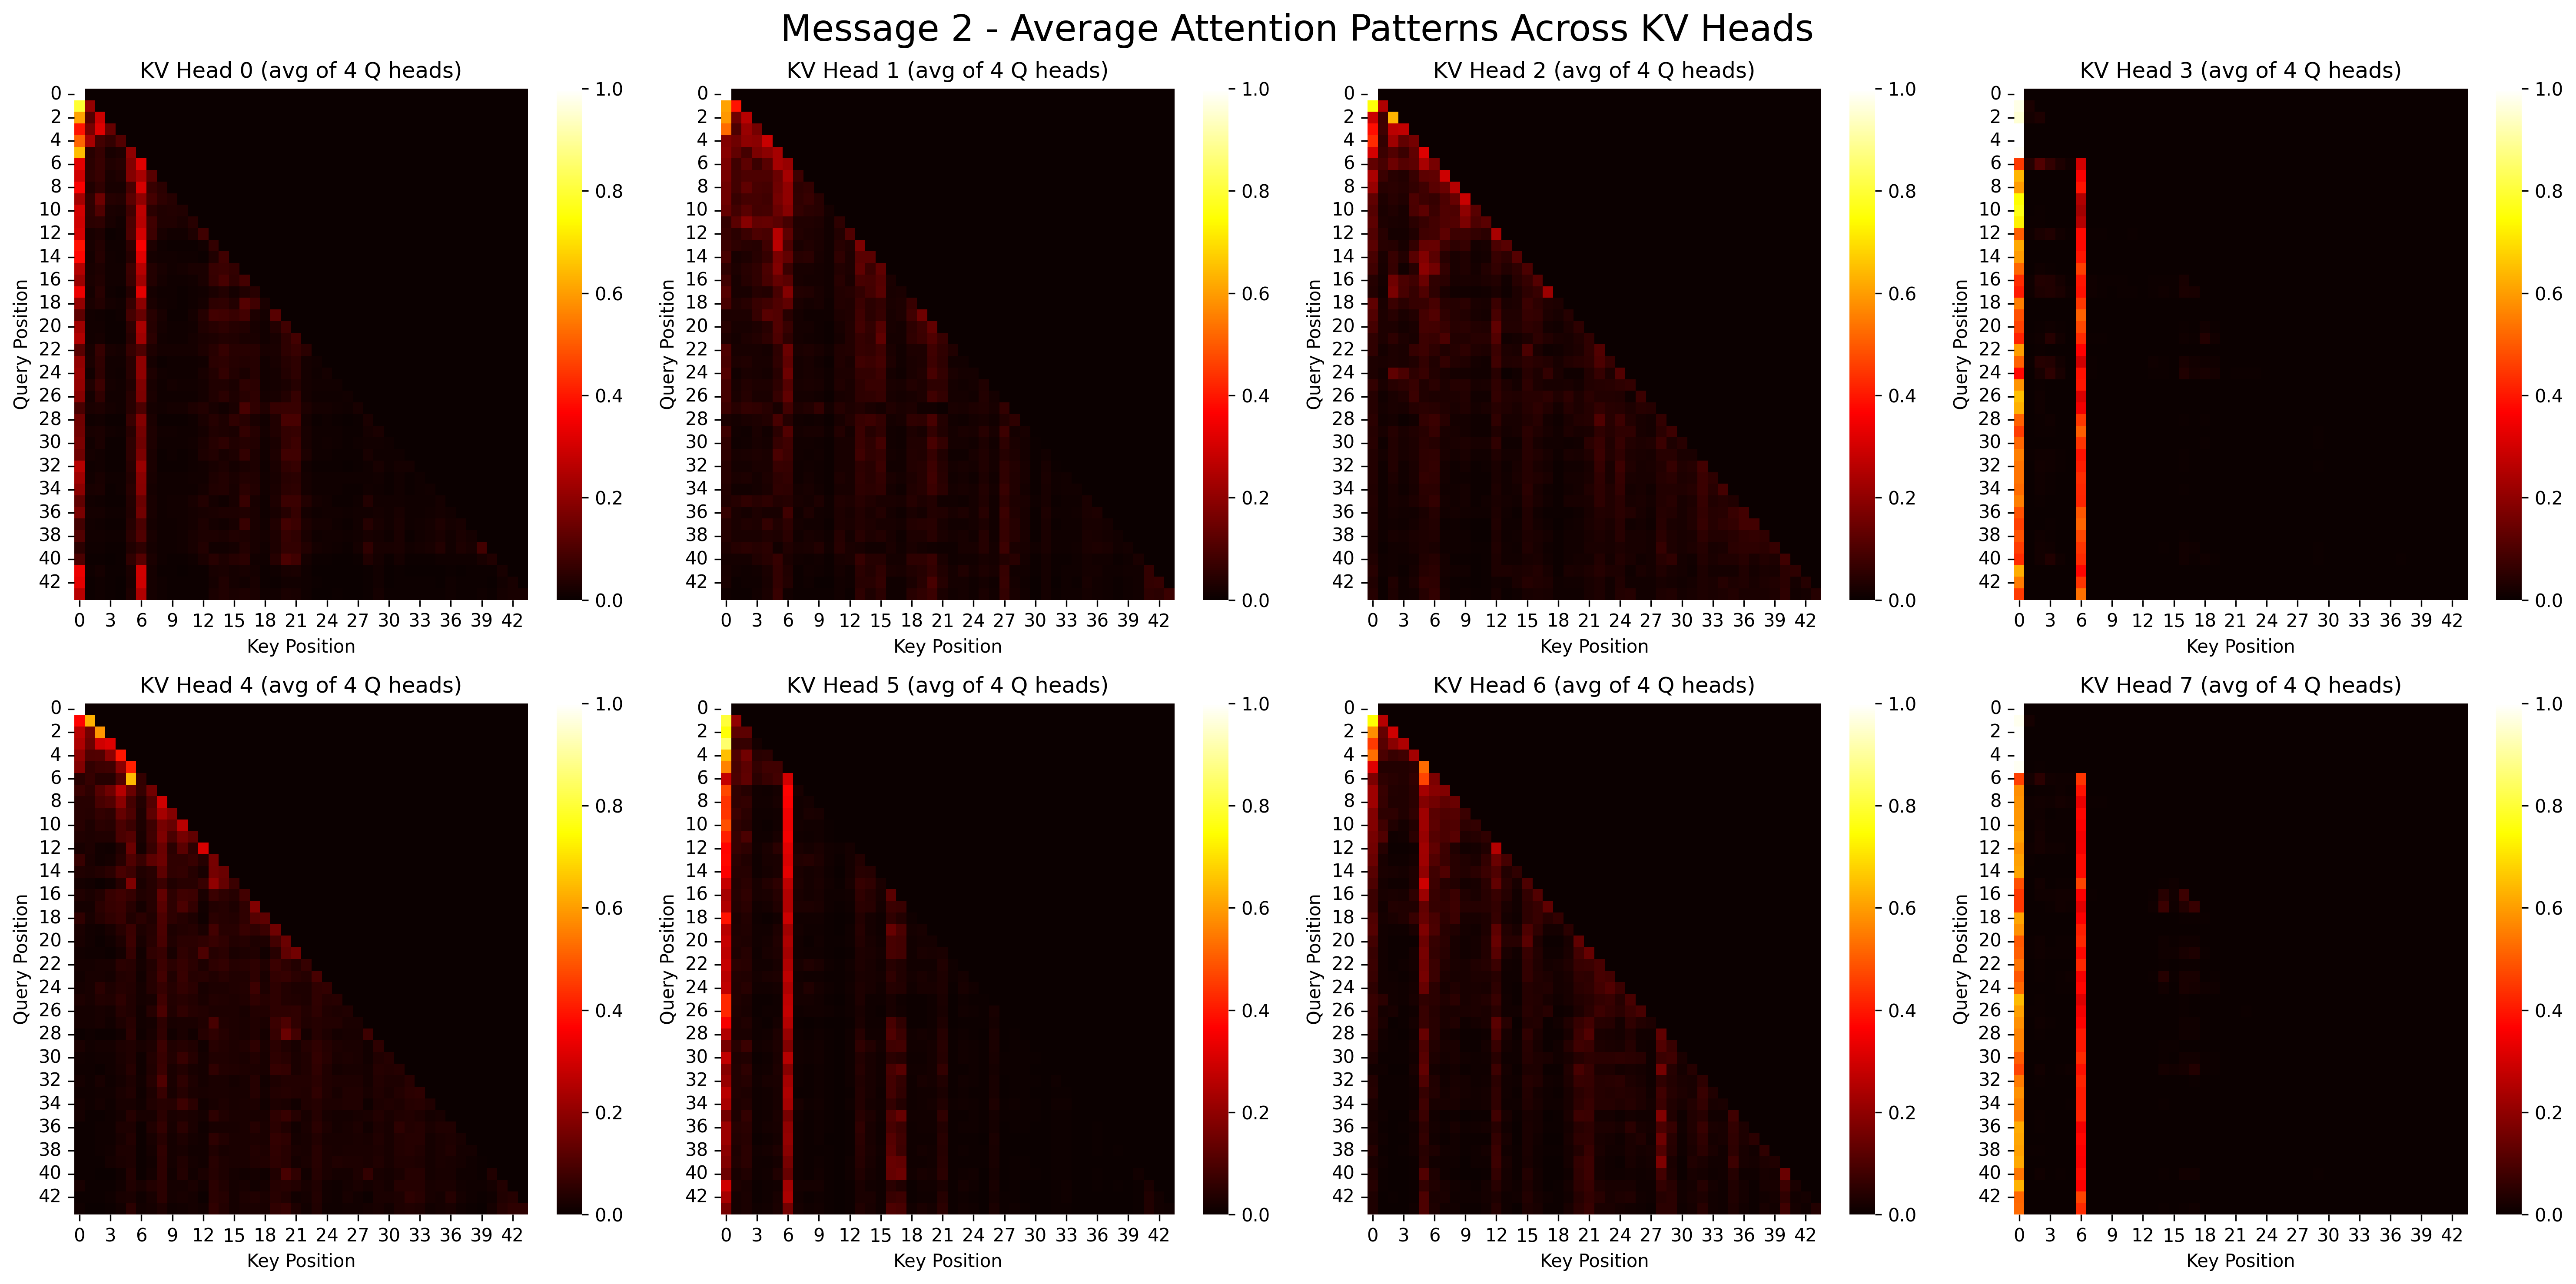

In [ ]:
# Visualize attention patterns
visualize_gqa_attention(attention_msg1, title_prefix="Message 1 -")
visualize_gqa_attention(attention_msg2, title_prefix="Message 2 -")

 ## 10. Implementing KV Caching

 Now we'll demonstrate how KV caching works. We'll:
 1. Find the common prefix between our two prompts
 2. Create a hybrid KV cache that reuses cached values for the common prefix
 3. Compare attention patterns with and without caching

In [ ]:
def find_common_prefix_length(tokens1, tokens2):
    """Find the length of common prefix between two token sequences."""
    common_prefix_length = 0
    for i in range(min(len(tokens1), len(tokens2))):
        if tokens1[i] == tokens2[i]:
            common_prefix_length += 1
        else:
            break
    return common_prefix_length


def create_hybrid_kv_cache(q2_mh, k1_mh, k2_mh, v1_mh, v2_mh, common_prefix_length):
    """Create hybrid K,V matrices using cached values for common prefix."""
    if common_prefix_length == 0:
        return k2_mh, v2_mh

    hybrid_k = k2_mh.clone()
    hybrid_v = v2_mh.clone()

    # Only copy the common prefix!
    hybrid_k[:, :common_prefix_length, :] = k1_mh[:, :common_prefix_length, :]
    hybrid_v[:, :common_prefix_length, :] = v1_mh[:, :common_prefix_length, :]

    # Let's add some verification
    print("Verifying cache creation:")
    print(f"Common prefix length: {common_prefix_length}")
    print(f"Total sequence length: {k2_mh.shape[1]}")
    print("For prefix tokens: hybrid_k should match k1_mh")
    print("For non-prefix tokens: hybrid_k should match k2_mh")

    return hybrid_k, hybrid_v

 ## 11. Finding the Common Prefix

 Let's identify the common prefix between our two prompts,
 which will be the part we can cache.

In [ ]:
# Extract token sequences from both prompts
tokens1 = data_obj1["input_tokens"][0].tolist()
tokens2 = data_obj2["input_tokens"][0].tolist()

# Find common prefix length
common_prefix_length = find_common_prefix_length(tokens1, tokens2)
print(f"Common prefix length: {common_prefix_length} tokens")

# Display the common prefix tokens
print("\nCommon Prefix Tokens:")
for i in range(common_prefix_length):
    token = tokens1[i]
    decoded = tokenizer.decode([token])
    print(f"Token {i}: {token} - '{decoded}'")

Common prefix length: 27 tokens

Common Prefix Tokens:
Token 0: 1 - '<s>'
Token 1: 529 - '<'
Token 2: 29989 - '|'
Token 3: 5205 - 'system'
Token 4: 29989 - '|'
Token 5: 29958 - '>'
Token 6: 13 - '
'
Token 7: 3492 - 'You'
Token 8: 526 - 'are'
Token 9: 263 - 'a'
Token 10: 8444 - 'helpful'
Token 11: 20255 - 'assistant'
Token 12: 29889 - '.'
Token 13: 2 - '</s>'
Token 14: 29871 - ''
Token 15: 13 - '
'
Token 16: 29966 - '<'
Token 17: 29989 - '|'
Token 18: 1792 - 'user'
Token 19: 29989 - '|'
Token 20: 29958 - '>'
Token 21: 13 - '
'
Token 22: 5618 - 'What'
Token 23: 338 - 'is'
Token 24: 278 - 'the'
Token 25: 7483 - 'capital'
Token 26: 310 - 'of'


 ## 12. Creating and Evaluating the Hybrid KV Cache

 Now let's create a hybrid KV cache and compare the attention patterns
 with and without caching to verify that the results are identical.
 `this is the secret sauce` **<<< watch closely >>>**

Verifying cache creation:
Common prefix length: 27
Total sequence length: 44
For prefix tokens: hybrid_k should match k1_mh
For non-prefix tokens: hybrid_k should match k2_mh
Maximum difference in attention values: 0.00000000
Mean difference: 0.00000000
By caching KV for the common prefix, you save:
 - 61.4% of KV computations
 - 61.4% of attention computations


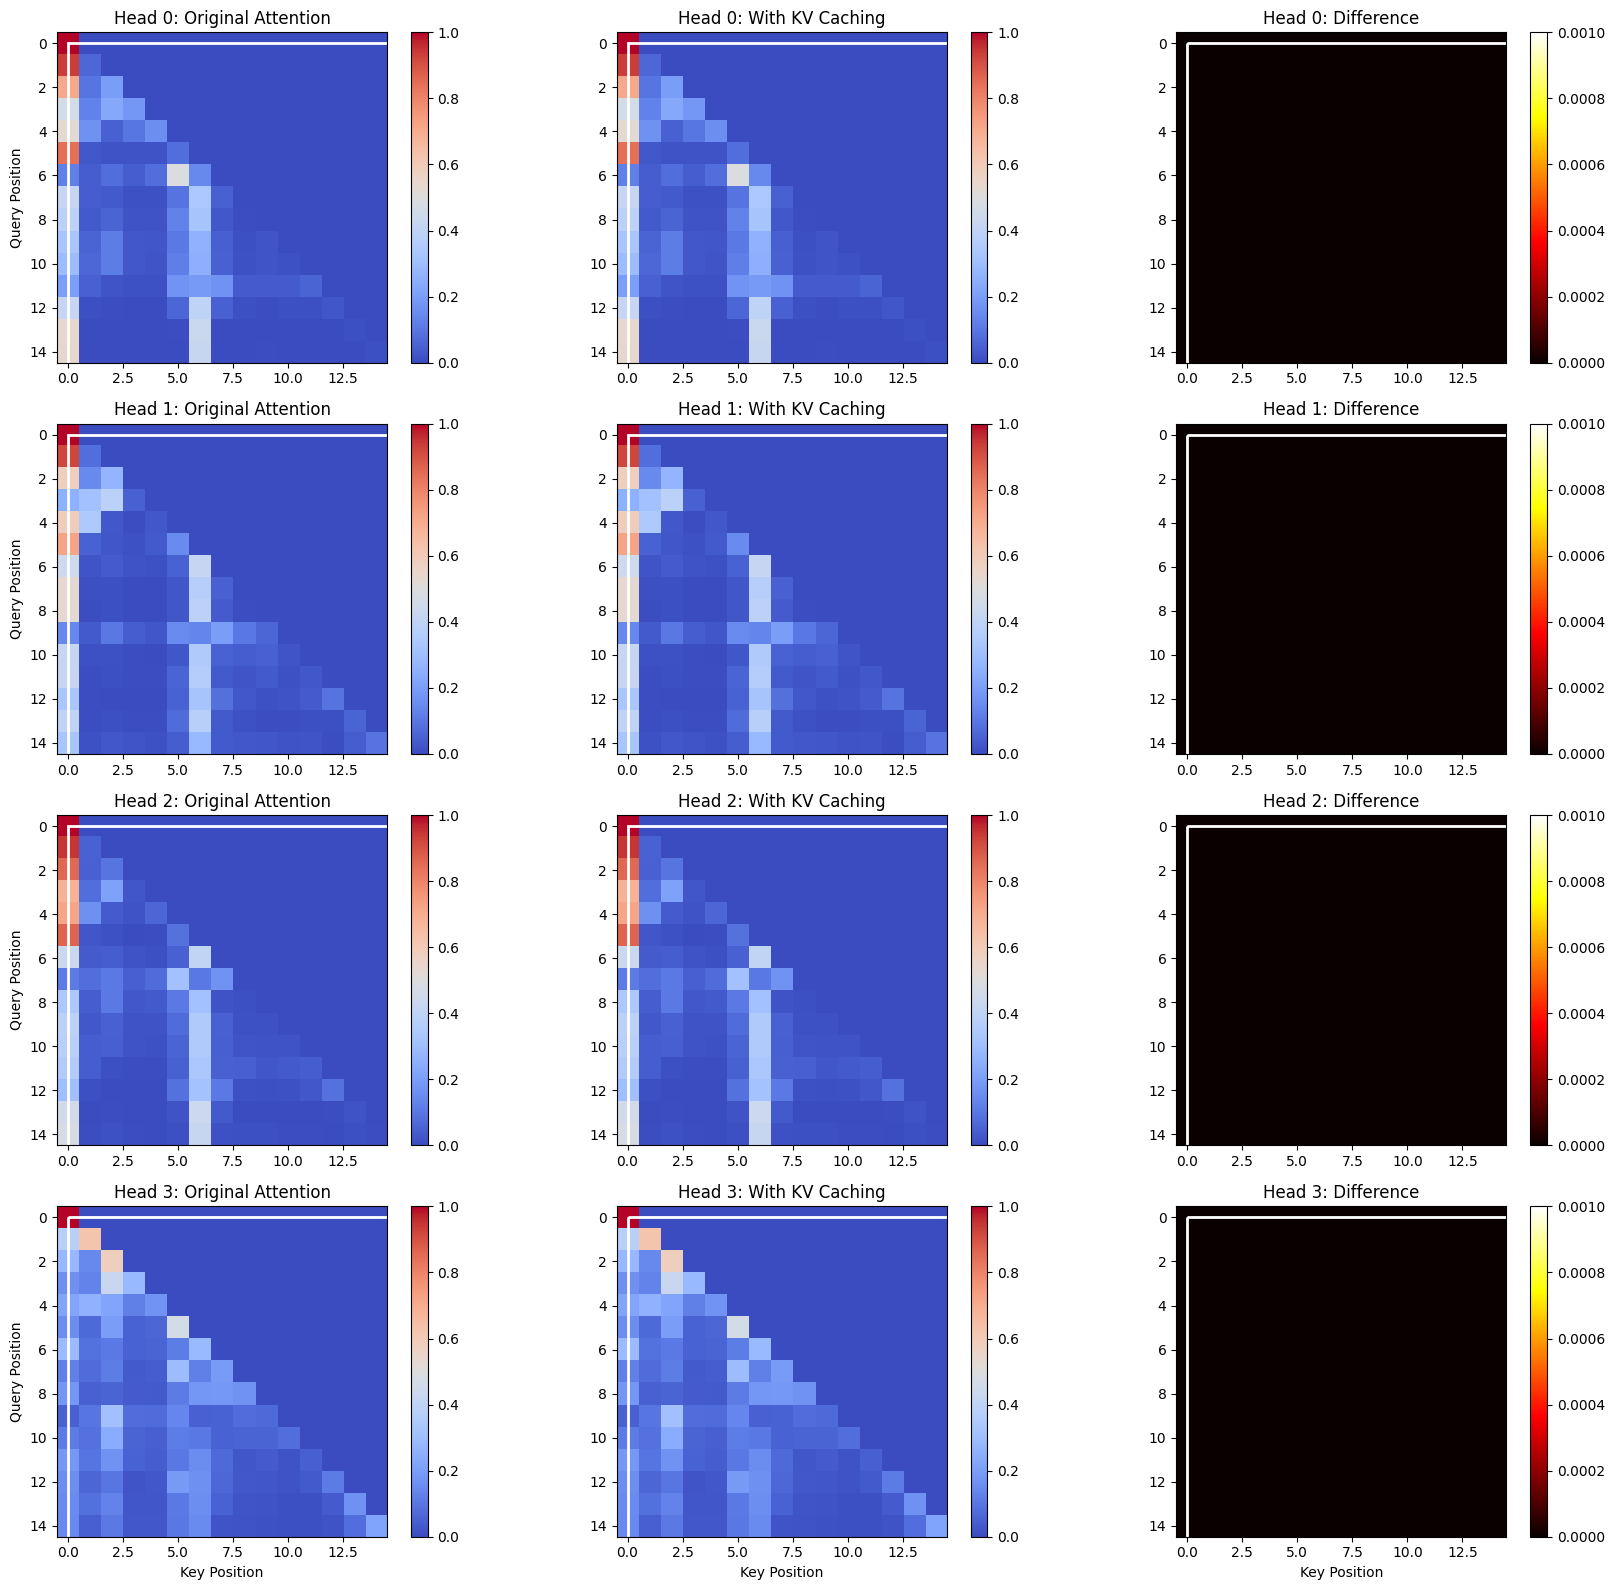

In [ ]:
# Create hybrid cached version using common prefix
hybrid_k, hybrid_v = create_hybrid_kv_cache(
    q2_mh, k1_mh, k2_mh, v1_mh, v2_mh, common_prefix_length
)

# Compute attention with and without caching
original_attention = compute_multihead_attention(q2_mh, k2_mh, v2_mh)
cached_attention = compute_multihead_attention(q2_mh, hybrid_k, hybrid_v)

# Visualize the difference in attention patterns
max_tokens = min(15, len(tokens2))
diff_attn = plot_attention_matrices(
    original_attention, cached_attention, common_prefix_length, max_tokens
)

# Print statistics and computational savings
print(f"Maximum difference in attention values: {np.max(diff_attn):.8f}")
print(f"Mean difference: {np.mean(diff_attn):.8f}")

if common_prefix_length > 0:
    token_savings = common_prefix_length / len(tokens2)
    compute_savings = (common_prefix_length * len(tokens2)) / (
        len(tokens2) * len(tokens2)
    )
    print(f"By caching KV for the common prefix, you save:")
    print(f" - {token_savings:.1%} of KV computations")
    print(f" - {compute_savings:.1%} of attention computations")

 ## 13. Visualizing Individual KV Vectors

 Finally, let's visualize the actual K and V vectors for specific tokens
 to confirm that our caching mechanism is working correctly.

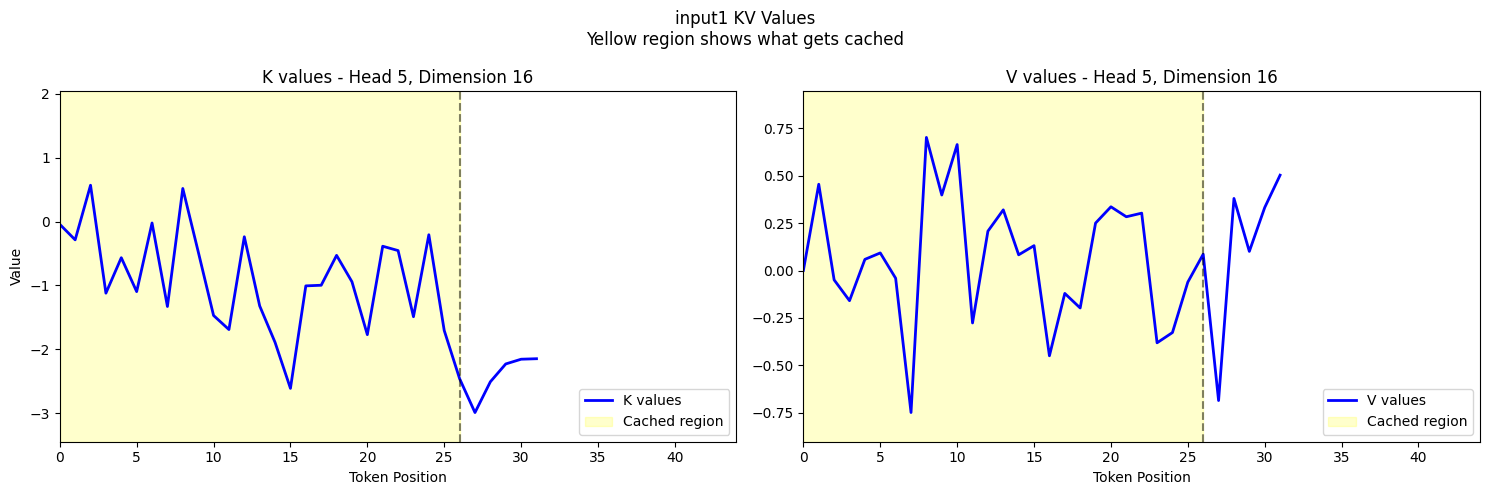

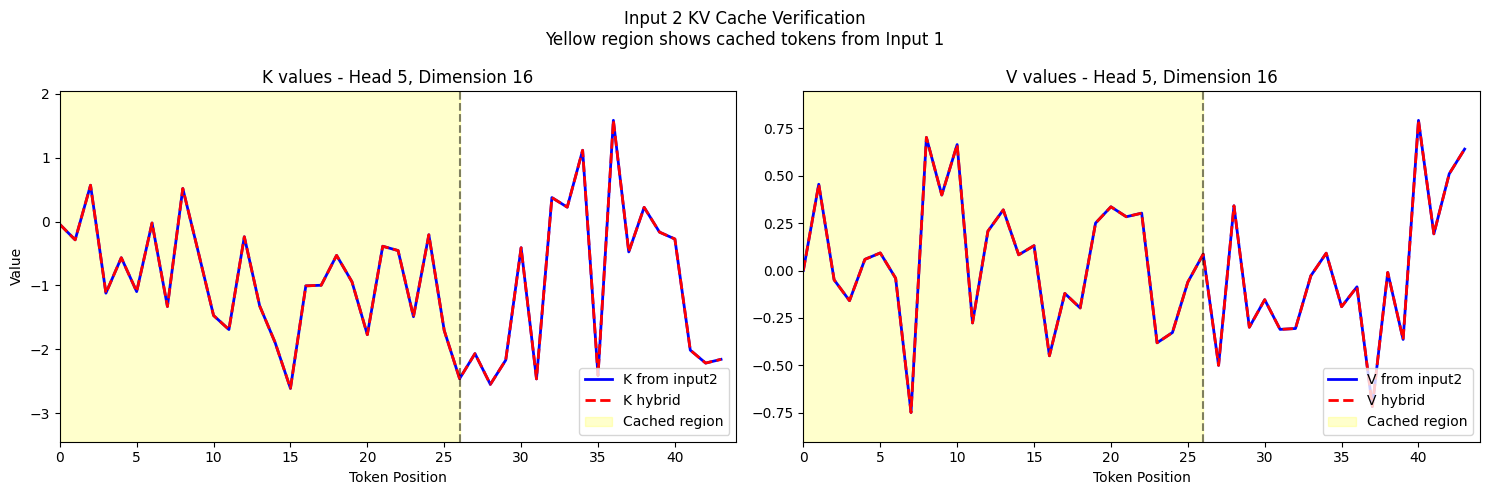

In [ ]:
if common_prefix_length > 0:
    # Get common axis limits for consistent visualization
    head_idx = 5
    k_limits, v_limits = get_axis_limits(
        k1_mh, k2_mh, v1_mh, v2_mh, hybrid_k, hybrid_v, head_idx, k1_mh.shape[-1] // 2
    )

    # Calculate maximum sequence length
    max_seq_len = max(k1_mh.shape[1], k2_mh.shape[1])

    # Plot input1's KV values (what gets cached)
    fig1 = plot_kv_cache_verification(
        k1_mh,
        v1_mh,
        common_prefix_length,
        k_limits,
        v_limits,
        max_seq_len,
        input_name="input1",
    )
    plt.show()

    # Plot input2's verification with hybrid cache
    fig2 = plot_hybrid_verification(
        k2_mh,
        v2_mh,
        hybrid_k,
        hybrid_v,
        common_prefix_length,
        k_limits,
        v_limits,
        max_seq_len,
    )
    plt.show()

 ## 14. Conclusion

 In this notebook, we've demonstrated stripped down version of how KV caching works in transformer models:

 1. We loaded a model and generated text for two different prompts
 2. We extracted Q, K, V projections from the model's attention layers
 3. We found the common prefix between the prompts
 4. We created a hybrid KV cache that reuses cached values for the common prefix
 5. We verified that attention patterns are identical with and without caching
 6. We quantified the computational savings from KV caching

 The key insight is that K and V values for tokens that remain the same across
 prompts don't need to be recomputed. This optimization is crucial for efficient
 text generation in large language models, especially for long contexts.